In [1]:
import os
import plaid
import requests
import datetime
import json
import pandas as pd
%matplotlib inline

In [2]:
def pretty_print_response(response):
  print(json.dumps(response, indent=4, sort_keys=True))

In [3]:
PLAID_CLIENT_ID = os.getenv('PLAID_CLIENT_ID')
PLAID_SECRET = os.getenv('PLAID_SECRET')
PLAID_PUBLIC_KEY = os.getenv('PLAID_PUBLIC_KEY')
PLAID_ENV = os.getenv('PLAID_ENV', 'sandbox')
PLAID_PRODUCTS = os.getenv('PLAID_PRODUCTS', 'transactions')

# Plaid Access Token

### 1. Create a client to connect to plaid

In [4]:
INSITUTION_ID = "ins_109508"

In [5]:
# YOUR CODE HERE
client = plaid.Client(client_id=PLAID_CLIENT_ID, secret=PLAID_SECRET, public_key=PLAID_PUBLIC_KEY, environment='sandbox')


### 2. Generate a public token

In [6]:
# Create public token to be exchanged for institution access token
create_tkn_response = client.Sandbox.public_token.create(INSITUTION_ID, ['transactions','income','assets'])

### 3. Exchange the public token for an access token

In [7]:
# Exchange public token for access token
exchange_response = client.Item.public_token.exchange(create_tkn_response['public_token'])

# Store access token as variable
access_token = exchange_response['access_token']

---

# Account Transactions with Plaid

### 1.Transactions for the last 90 days

In [38]:
# Transactions for institution for specific date range
start_date = '{:%Y-%m-%d}'.format(datetime.datetime.now() + datetime.timedelta(-100))#It should be 90 instead of 100 but then it would show less data.
end_date = '{:%Y-%m-%d}'.format(datetime.datetime.now())

# Transactions for date range
transaction_response = client.Transactions.get(access_token,start_date,end_date)
transactions90 = transaction_response['transactions']

### 2. Categories for each transaction

In [39]:
categories = [transactions90[i]['category']
     for i in range(len(transactions90))]
print(categories)

[['Payment', 'Credit Card'], ['Travel', 'Car Service', 'Ride Share'], ['Transfer', 'Debit'], ['Transfer', 'Deposit'], ['Recreation', 'Gyms and Fitness Centers'], ['Travel', 'Airlines and Aviation Services'], ['Food and Drink', 'Restaurants'], ['Food and Drink', 'Restaurants', 'Coffee Shop'], ['Food and Drink', 'Restaurants'], ['Transfer', 'Credit'], ['Travel', 'Airlines and Aviation Services'], ['Travel', 'Car Service', 'Ride Share'], ['Food and Drink', 'Restaurants'], ['Payment'], ['Food and Drink', 'Restaurants'], ['Shops', 'Sporting Goods'], ['Payment', 'Credit Card'], ['Travel', 'Car Service', 'Ride Share'], ['Transfer', 'Debit'], ['Transfer', 'Deposit'], ['Recreation', 'Gyms and Fitness Centers'], ['Travel', 'Airlines and Aviation Services'], ['Food and Drink', 'Restaurants'], ['Food and Drink', 'Restaurants', 'Coffee Shop'], ['Food and Drink', 'Restaurants'], ['Transfer', 'Credit'], ['Travel', 'Airlines and Aviation Services'], ['Travel', 'Car Service', 'Ride Share'], ['Food and 

### 3. New DataFrame using the following fields from the JSON transaction data: date, name, amount, category. 

In [40]:
dates = [transactions90[i]['date']
     for i in range(len(transactions90))]

names = [transactions90[i]['name']
     for i in range(len(transactions90))]

amounts = [transactions90[i]['amount']
     for i in range(len(transactions90))]

category1 = []
for x in categories:
    category1.append(x[0])

df = pd.DataFrame(list(zip(dates, names, amounts, category1)), 
               columns =['Dates', 'Name', 'Amount', 'Category']) 
df.tail() 

,Dates,Name,Amount,Category
53,2019-06-18,United Airlines,-500.00,Travel
54,2019-06-17,McDonald's,12.00,Food and Drink
55,2019-06-17,Starbucks,4.33,Food and Drink
56,2019-06-16,SparkFun,89.40,Food and Drink
57,2019-06-15,INTRST PYMNT,-4.22,Transfer


### 4. Converting the data types to the appropriate types 

In [41]:
# YOUR CODE HERE
df['datetime'] = pd.to_datetime(df['Dates'])
df_indexed = df.set_index('datetime')
df_indexed.drop(['Dates'], axis=1, inplace=True)
df_indexed.head()

,Name,Amount,Category
datetime,,,
2019-09-18,CREDIT CARD 3333 PAYMENT *//,25.0,Payment
2019-09-18,Uber 063015 SF**POOL**,5.4,Travel
2019-09-17,ACH Electronic CreditGUSTO PAY 123456,5850.0,Transfer
2019-09-17,CD DEPOSIT .INITIAL.,1000.0,Transfer
2019-09-16,Touchstone Climbing,78.5,Recreation


In [42]:
df_indexed.Amount.dtype

dtype('float64')

---

# Income Analysis with Plaid

In this section, you will use the Plaid Sandbox to complete the following:
1. Determine the previous year's gross income and print the results
2. Determine the current monthly income and print the results
3. Determine the projected yearly income and print the results

In [43]:
# YOUR CODE HERE
income_response = client.Income.get(access_token)
income_response
print(f"Last year gross income was = USD {income_response['income']['last_year_income_before_tax']}")
print(f"Current monthly income is = USD {income_response['income']['income_streams'][0]['monthly_income']}")
print(f"The projected gross yearly income is = USD {income_response['income']['projected_yearly_income_before_tax']}")

Last year gross income was = USD 7893
Current monthly income is = USD 500
The projected gross yearly income is = USD 7389


---

# Budget Analysis
In this section, you will use the transactions DataFrame to analyze the customer's budget

1. Calculate the total spending per category and print the results (Hint: groupby or count transactions per category)
2. Generate a bar chart with the number of transactions for each category 
3. Calulate the expenses per month
4. Plot the total expenses per month

### Calculate the expenses per category

In [44]:
# Table with Expenses per category
category_grp = df.groupby(['Category']).sum()
category_grp.sort_values(by="Amount", ascending=True, inplace=True)
category_grp

,Amount
Category,
Travel,-459.41
Recreation,314.00
Shops,1500.00
Food and Drink,3422.92
Payment,6335.50
Transfer,27383.12


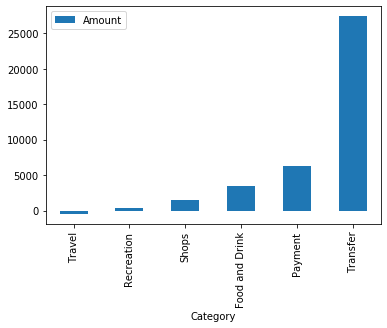

In [45]:
#Bar chart with expenses per category
category_grp.plot(kind='bar')

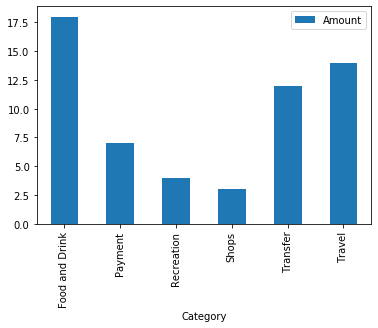

In [46]:
# Bar chart with number of transactions per category
category_count = df.groupby(['Category']).count()
category_count.drop(["Name", "Dates", "datetime"], axis=1, inplace=True)
category_count.plot(kind='bar')

### Calculate the expenses per month

In [47]:
# YOUR CODE HERE
df_indexed.tail()


,Name,Amount,Category
datetime,,,
2019-06-18,United Airlines,-500.00,Travel
2019-06-17,McDonald's,12.00,Food and Drink
2019-06-17,Starbucks,4.33,Food and Drink
2019-06-16,SparkFun,89.40,Food and Drink
2019-06-15,INTRST PYMNT,-4.22,Transfer


In [48]:
monthly_expeses = df_indexed.groupby(pd.Grouper(freq='M')).sum()
monthly_expeses

,Amount
datetime,
2019-06-30,10138.91
2019-07-31,10645.24
2019-08-31,10645.24
2019-09-30,7066.74


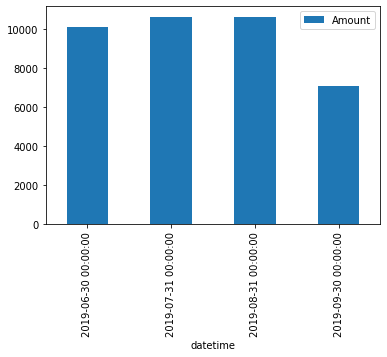

In [49]:
monthly_expeses.plot(kind='bar')